# Profiling and Analysis Questions

- Do users purchase different products at different time of day?
- What clusters of aisle purchase standout?
- Do users who reorder have different behaviour? 
- does the behaviour change per number of order (eg.: min vs median, etc)
- do users purchase differently depending on days or weeks since last purchase?
- do users purchase differently on the weekends vs weekday?
- What is the top product/aisle purchased first or last per order?
- Reordered is per product. what products are most reordered by users?
- how many orders per user_id? 

## Aggregations
- days/weeks since last order
- number of orders (better to consider order number instead of count of order_id due to incomplete customer history)
- number of users who reordered
- orders per time of day (numeric or discrete count)


# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart User Aggregated Behaviour"


## DSLabs

In [2]:
%run "scripts/dslabs_functions.py"

# data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
# test_data=True
test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    # sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    # sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    # users_df=users_df.sample(frac=sample)





data=users_df.copy()

id_cols=['user_id']


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        206209 non-null  int64  
 1   total_orders                   206209 non-null  int64  
 2   mean_products                  206209 non-null  float64
 3   max_products                   206209 non-null  int64  
 4   std_num_products               206209 non-null  float64
 5   mean_lag_between_orders        206209 non-null  float64
 6   std_lag_between_orders         206209 non-null  float64
 7   mean_reorder_rate              206209 non-null  float64
 8   mean_weekend_order_rate        206209 non-null  float64
 9   mean_order_dow                 206209 non-null  float64
 10  top_order_dow                  206209 non-null  int64  
 11  order_dow_variety              206209 non-null  int64  
 12  top_order_hour                

# Dimensionality

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


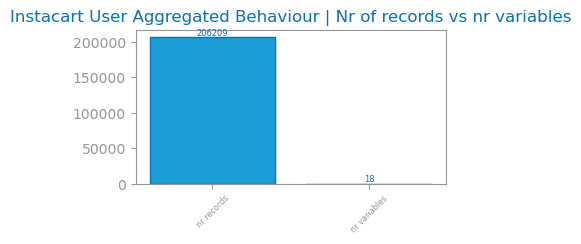

In [5]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title=f"{file_tag} | Nr of records vs nr variables"
)
# savefig(f"{file_tag}_records_variables.png")
show()

## Missing values
- Only missing values for dataset are the columns "days since last order" at 6.5%. When the order is the user's first, this column shows empty values. It cannot be filled with '0' since there are users that can make multiple orders in the same day. Would not remove it as well as it can be used for analysis questions like 'behaviour on first order'?

In [6]:
data.isnull().sum()


user_id                          0
total_orders                     0
mean_products                    0
max_products                     0
std_num_products                 0
mean_lag_between_orders          0
std_lag_between_orders           0
mean_reorder_rate                0
mean_weekend_order_rate          0
mean_order_dow                   0
top_order_dow                    0
order_dow_variety                0
top_order_hour                   0
order_hour_variety               0
std_order_hour                   0
mean_peak_time_of_day_rate       0
top_order_time_of_day_enc        0
order_time_of_day_enc_variety    0
dtype: int64

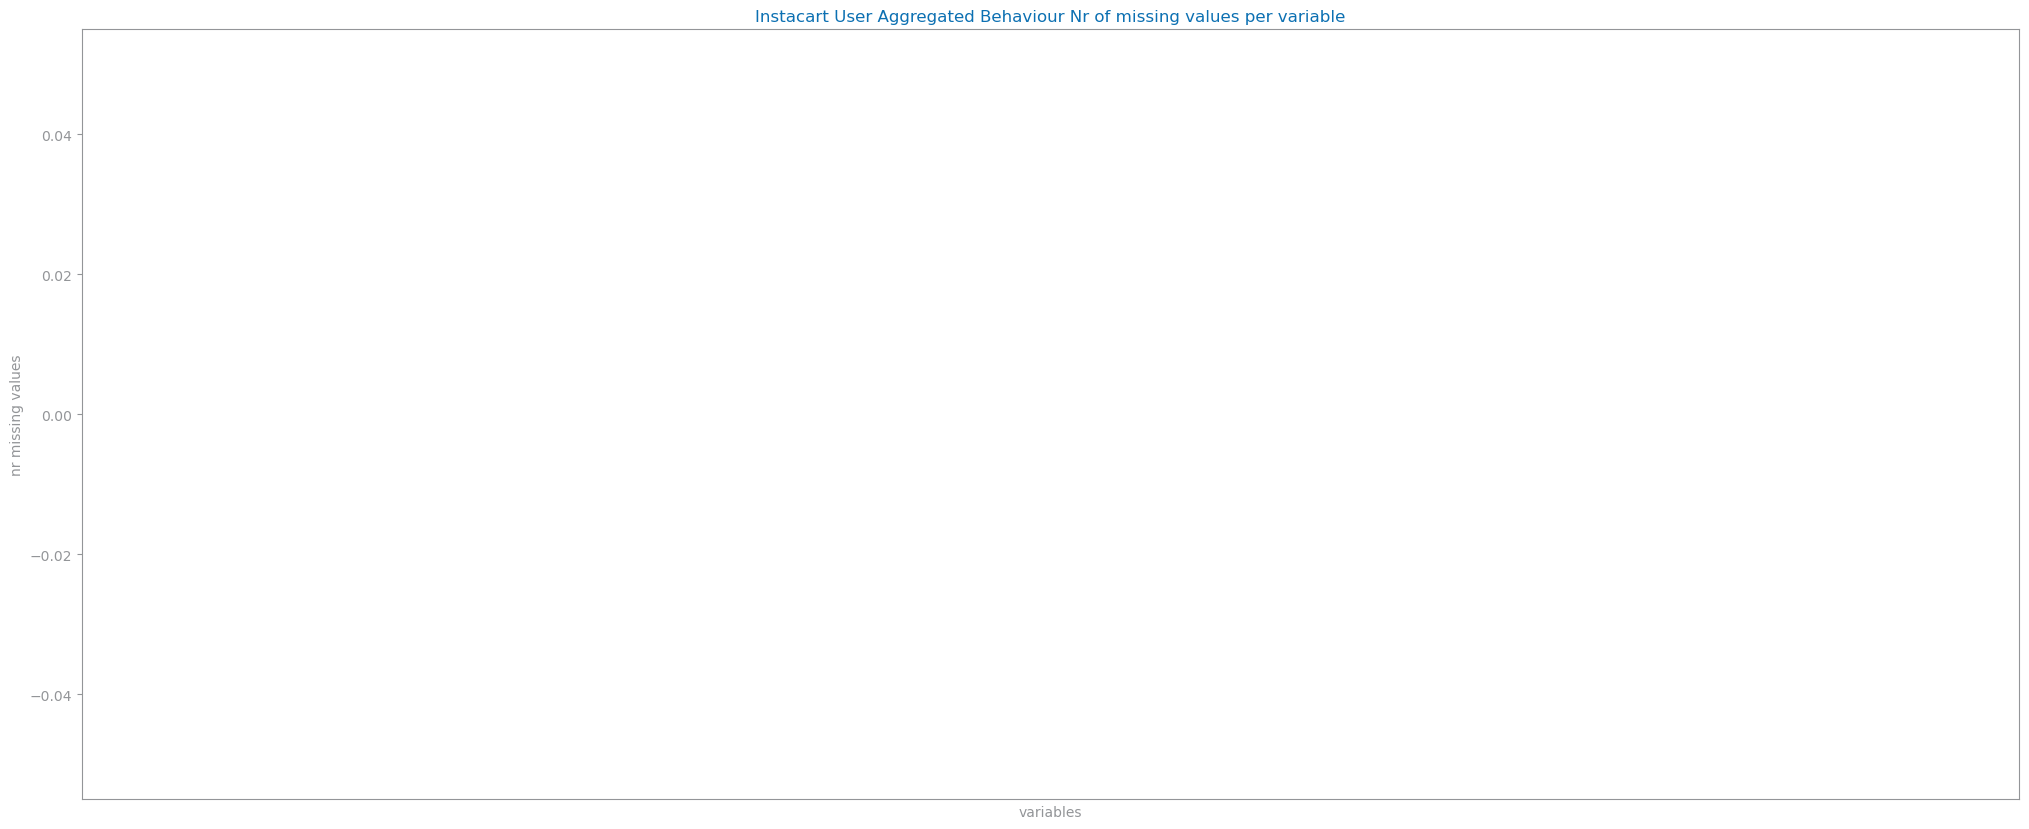

In [7]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

mv: dict[str, int] = {}
total_rows = len(data)

for var in data.columns:
    nr: int = data[var].isna().sum()
    if nr > 0:
        percentage = (nr / total_rows) * 100
        mv[var] = (nr, percentage)

sorted_mv = dict(sorted(mv.items(), key=lambda item: item[1][0], reverse=True))

variables = list(sorted_mv.keys())
missing_values = [val[0] for val in sorted_mv.values()]
percentages = [val[1] for val in sorted_mv.values()]

figure(figsize=(25, 10)) #(largura,altura) 

plot_bar_chart(
    variables,
    missing_values,
    title=f"{file_tag} Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
for i, (var, perc) in enumerate(zip(variables, percentages)):
    text(i, missing_values[i] + max(missing_values) * 0.08, f"{perc:.1f}%", ha="center", va="center_baseline")

savefig(f"images/{file_tag}_mv.png")
show()

## Variables Type

In [8]:
data.dtypes


user_id                            int64
total_orders                       int64
mean_products                    float64
max_products                       int64
std_num_products                 float64
mean_lag_between_orders          float64
std_lag_between_orders           float64
mean_reorder_rate                float64
mean_weekend_order_rate          float64
mean_order_dow                   float64
top_order_dow                      int64
order_dow_variety                  int64
top_order_hour                     int64
order_hour_variety                 int64
std_order_hour                   float64
mean_peak_time_of_day_rate       float64
top_order_time_of_day_enc        float64
order_time_of_day_enc_variety      int64
dtype: object

In [9]:
from pandas import Series, to_numeric, to_datetime


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['total_orders', 'mean_products', 'max_products', 'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order_rate', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'mean_peak_time_of_day_rate', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


### variables per type plot

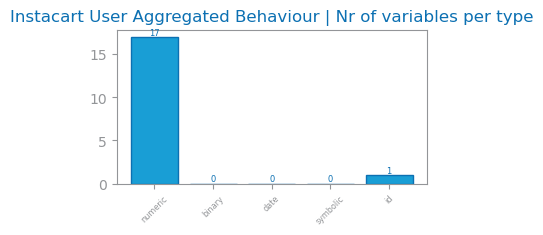

In [10]:
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title=f"{file_tag} | Nr of variables per type"
)
# savefig(f"{file_tag}_variable_types.png")
show()

# Data Distribution

## describe

In [11]:
summary5: DataFrame = data.describe(include="all")
summary5

,user_id,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,15.590367,11.839974,17.654865,3.949205,15.469670,6.616467,0.432249,0.266368,2.750055,2.521248,4.688724,13.265561,7.193789,3.309919,0.732076,1.673876,2.838669
std,59527.555167,16.654774,6.641591,10.192818,2.544586,7.207436,3.268528,0.212144,0.216570,1.014136,2.146838,1.682648,3.999611,3.874914,1.484847,0.237698,1.741754,0.818794
min,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.570796,1.000000
25%,51553.000000,5.000000,7.071429,10.000000,2.106773,9.553797,4.231001,0.267857,0.097938,2.113636,1.000000,3.000000,10.000000,4.000000,2.292392,0.587629,1.570796,2.000000
50%,103105.000000,9.000000,10.785714,16.000000,3.468528,14.692308,7.033376,0.428571,0.238710,2.753425,2.000000,5.000000,13.000000,6.000000,3.170481,0.772727,1.570796,3.000000
75%,154657.000000,19.000000,15.433333,23.000000,5.232778,20.724409,9.037772,0.595745,0.388889,3.370748,5.000000,6.000000,16.000000,10.000000,4.162512,0.937500,3.141593,3.000000
max,206209.000000,99.000000,78.551601,145.000000,46.803210,30.000000,21.213203,0.989529,1.000000,6.000000,6.000000,7.000000,23.000000,24.000000,12.165525,1.000000,3.141593,4.000000


## Numeric Variables

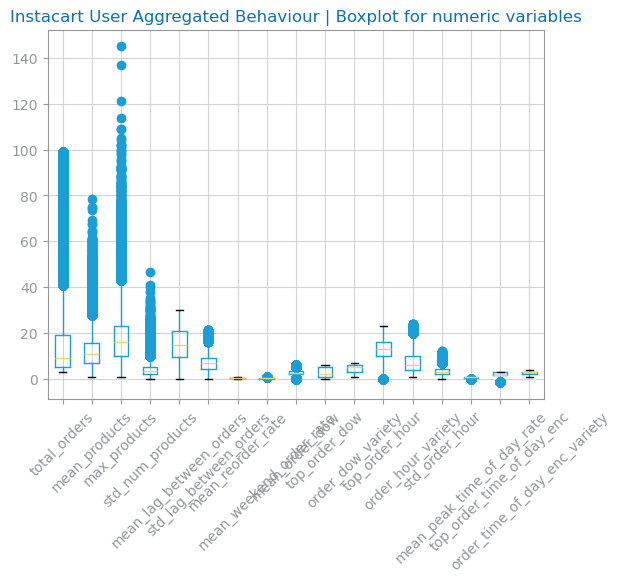

In [12]:
from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    data[numeric].boxplot(rot=45)
    title(f'{file_tag} | Boxplot for numeric variables')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

## numeric variables distribution breakdown
- add_to_cart_order, order number and weeks since last order should be truncated or removed

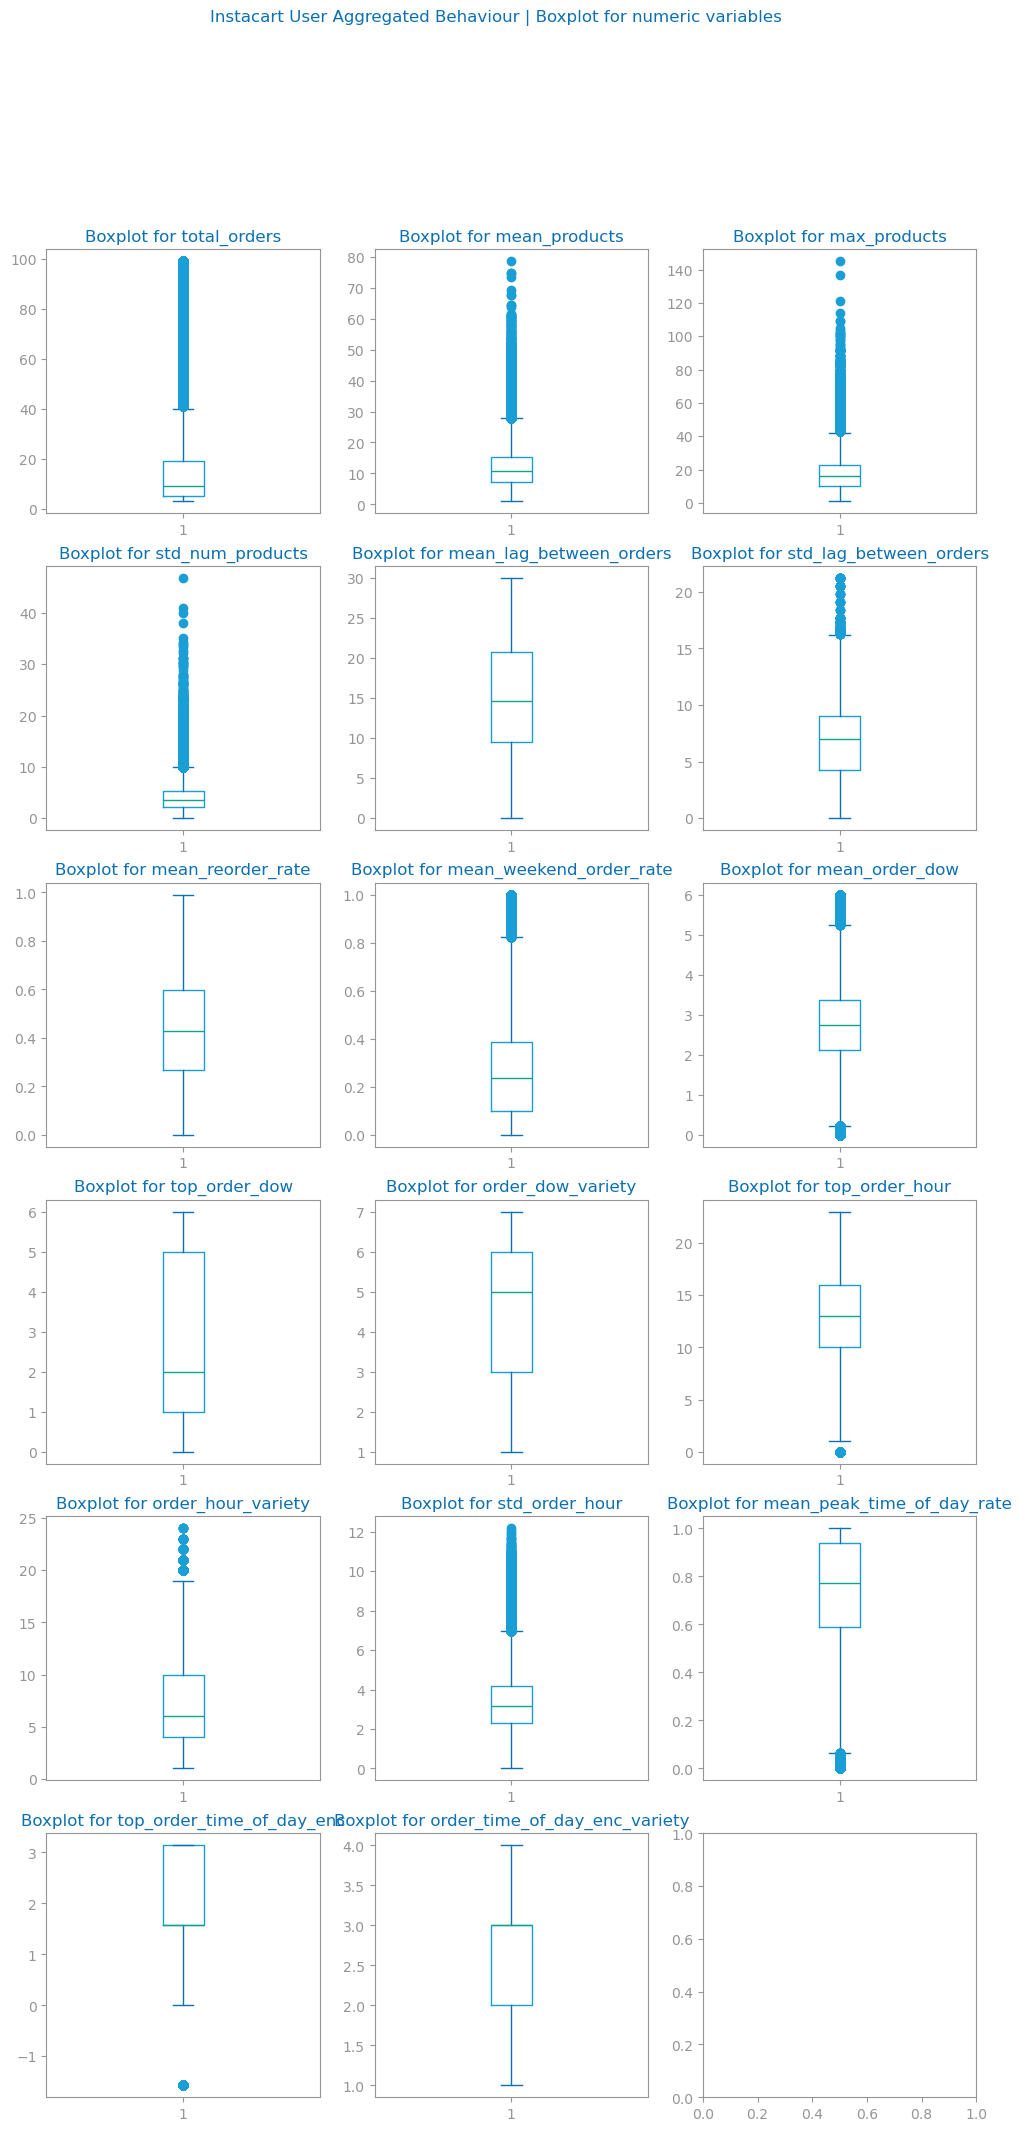

In [13]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## standard outliers for numeric variables

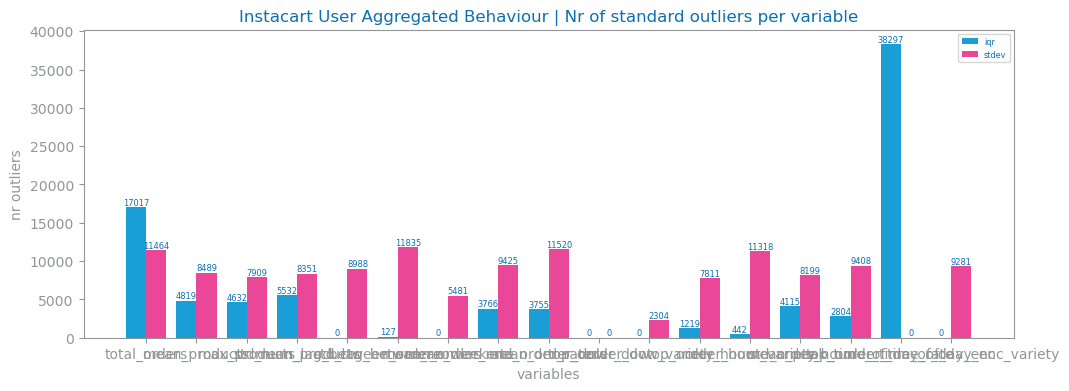

In [14]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

## outliers factorized

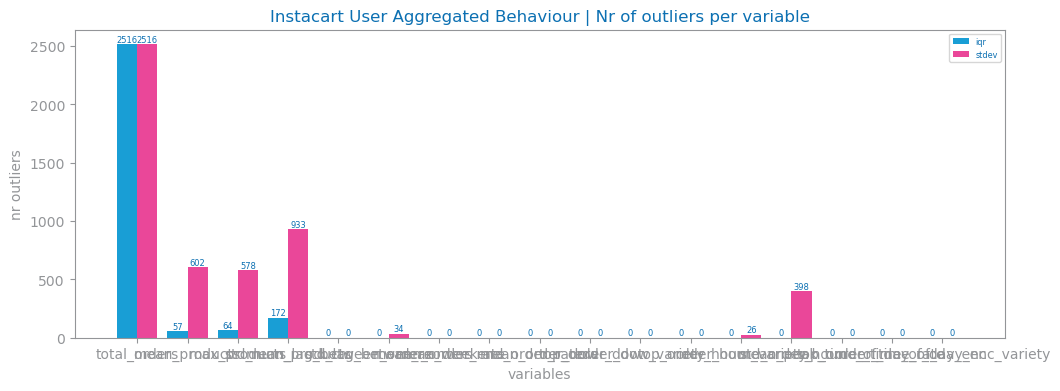

In [15]:
if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric, nrstdev=4, iqrfactor=4.5)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title=f"{file_tag} | Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers.png")
    show()
else:
    print("There are no numeric variables.")

## numeric histograms

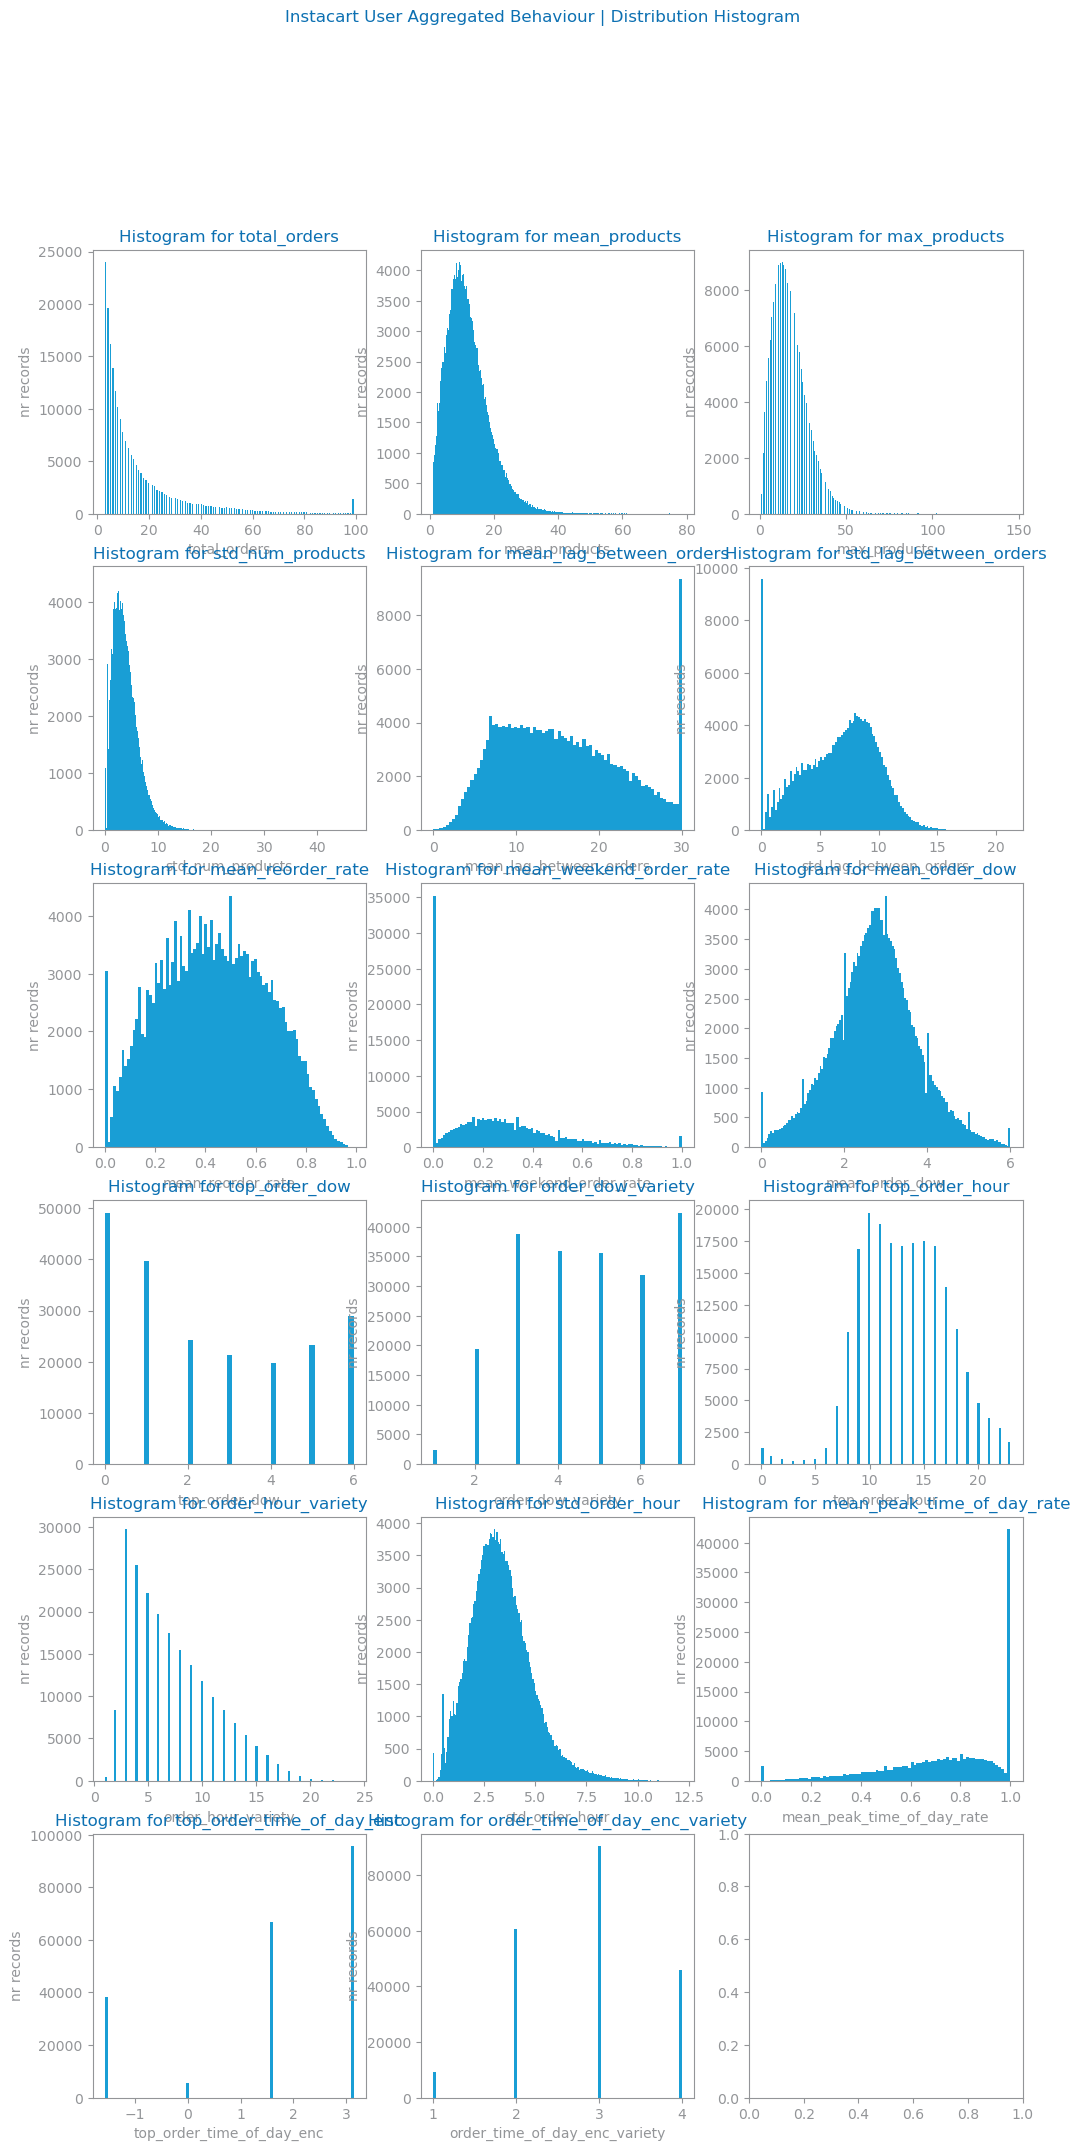

In [16]:
from dslabs_functions import set_chart_labels


if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    
    fig.suptitle(f'{file_tag} | Distribution Histogram')

    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

# Correlation Analysis

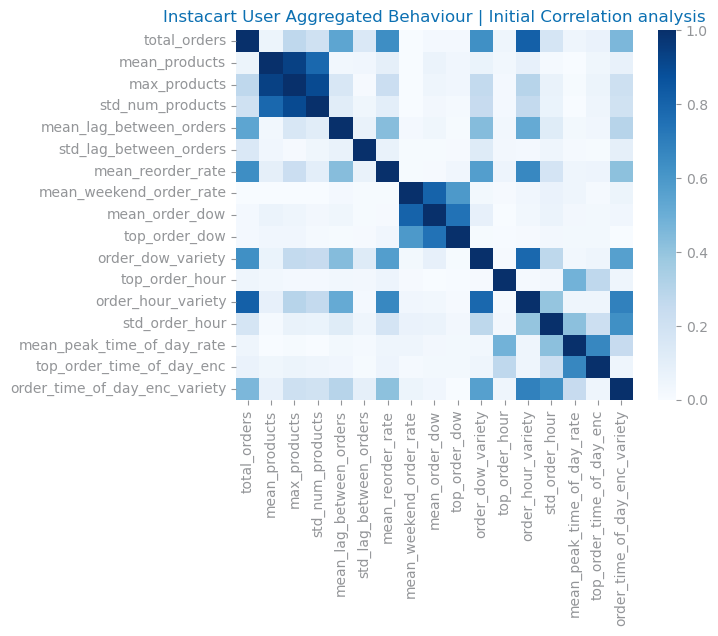

In [17]:
from seaborn import heatmap
from dslabs_functions import get_variable_types
from matplotlib.pyplot import figure, title, savefig, show

corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)

title(f'{file_tag} | Initial Correlation analysis')

savefig(f"images/{file_tag}_correlation_analysis.png")
show()

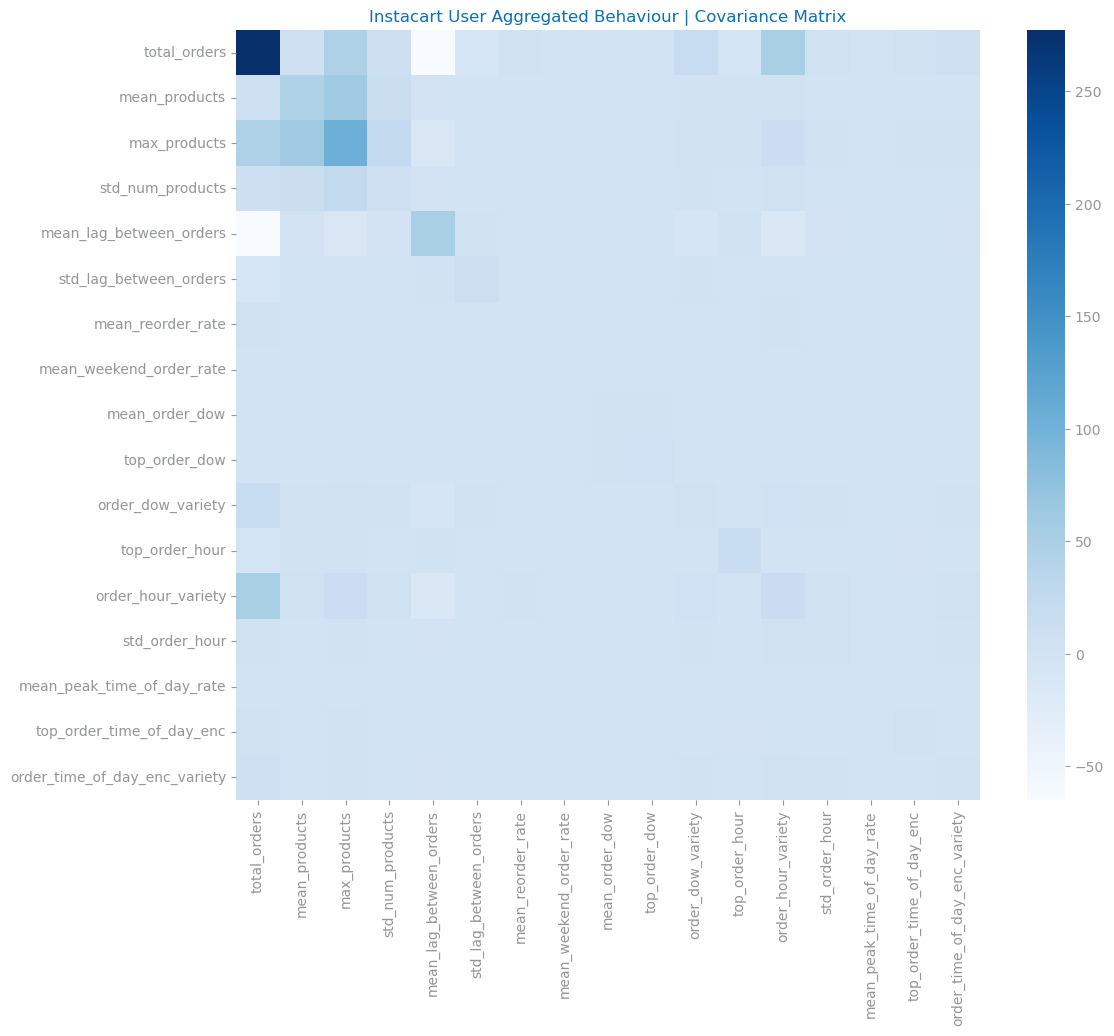

In [18]:
# Calculate the covariance matrix

cov_mtx: DataFrame = data[numeric].cov()

# Plot the covariance matrix
figure(figsize=(12, 10))
heatmap(
    cov_mtx,
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=cov_mtx.values.min(),
    vmax=cov_mtx.values.max(),
)

title(f'{file_tag} | Covariance Matrix')

savefig(f"images/{file_tag}_covariance_matrix.png")
show()